In [1]:
import pandas as pd
from pycaret.classification import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

df = pd.read_csv('./features.csv', sep='\t', encoding='utf-8')

df = df.dropna().drop(columns=['Unnamed: 0']).reset_index(drop=True)
df['Biological Sex'] = df['Biological Sex'].map({'FEMALE': 0, 'MALE': 1})

PersNorm    71.162691
PersHigh    15.235141
PersLow     13.602168
Name: label, dtype: float64


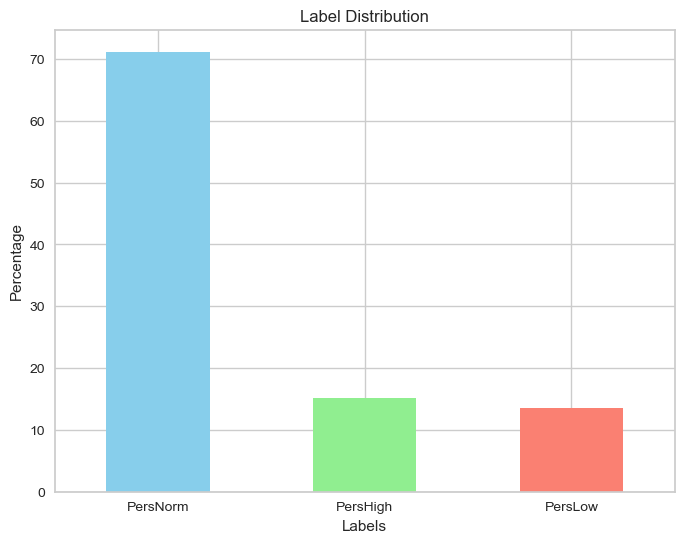

In [2]:
label_distribution = df['label'].value_counts(normalize=True) * 100
print(label_distribution)

plt.figure(figsize=(8, 6))
label_distribution.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

In [3]:
df['label'] = df['label'].map({'PersLow': 0, 'PersNorm': 1, 'PersHigh': 2})

X = df.drop(columns=['datetime', 'label', 'glucose'])
y = df['label']
data = pd.concat([X, y], axis=1)

rus = RandomUnderSampler(random_state=123)
X_resampled, y_resampled = rus.fit_resample(X, y)

# 언더 샘플링 후 데이터프레임 결합
data_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='label')], axis=1)

print(f"Data length: {len(data)}")
print(f"Data_resampled length: {len(data_resampled)}")

class_counts = data_resampled['label'].map({0:'PersLow',1:'PersNorm',2:'PersHigh'}).value_counts()
print(class_counts)

Data length: 28047
Data_resampled length: 11445
PersLow     3815
PersNorm    3815
PersHigh    3815
Name: label, dtype: int64


In [4]:
exp = setup(data=data_resampled,
            target='label',
            fold=10,        # 10-fold
            train_size=0.7, # training size 0.7:0.3
            fold_strategy='stratifiedkfold',
            fold_shuffle=True,
            feature_selection=True,
            feature_selection_method='classic',
            n_features_to_select=15,
            session_id=123,
            use_gpu=False)

best_model = compare_models()

print(best_model)


,Description,Value
0,Session id,123
1,Target,label
2,Target type,Multiclass
3,Original data shape,"(11445, 76)"
4,Transformed data shape,"(11445, 16)"
5,Transformed train set shape,"(8011, 16)"
6,Transformed test set shape,"(3434, 16)"
7,Numeric features,75
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8813,0.9648,0.8813,0.8808,0.8798,0.8219,0.8230,2.0080
rf,Random Forest Classifier,0.8764,0.9605,0.8764,0.8763,0.8744,0.8146,0.8164,2.0750
lightgbm,Light Gradient Boosting Machine,0.8246,0.9369,0.8246,0.8242,0.8217,0.7369,0.7393,2.8110
dt,Decision Tree Classifier,0.8190,0.8642,0.8190,0.8178,0.8170,0.7285,0.7297,1.8370
knn,K Neighbors Classifier,0.7576,0.9041,0.7576,0.7582,0.7512,0.6364,0.6417,1.8460
gbc,Gradient Boosting Classifier,0.6867,0.8517,0.6867,0.6866,0.6830,0.5300,0.5329,3.5720
ada,Ada Boost Classifier,0.5526,0.7279,0.5526,0.5517,0.5470,0.3289,0.3320,2.0690
qda,Quadratic Discriminant Analysis,0.4913,0.6927,0.4913,0.5236,0.4678,0.2370,0.2606,1.8880
lda,Linear Discriminant Analysis,0.4857,0.6611,0.4857,0.4881,0.4819,0.2286,0.2308,1.9080
ridge,Ridge Classifier,0.4853,0.0000,0.4853,0.4872,0.4807,0.2280,0.2306,1.9420


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=123, verbose=0, warm_start=False)


In [5]:
print("====Tuned model====")
tuned_model = tune_model(best_model)
predictions = predict_model(tuned_model)

final_model = finalize_model(tuned_model)
final_predictions = predict_model(final_model, data=data)

====Tuned model====


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6147,0.8105,0.6147,0.6401,0.6072,0.4219,0.4361
1,0.6504,0.8309,0.6504,0.6629,0.6377,0.4757,0.4887
2,0.6504,0.8400,0.6504,0.6682,0.6416,0.4757,0.4876
3,0.6217,0.8169,0.6217,0.6313,0.6134,0.4326,0.4423
4,0.6042,0.7921,0.6042,0.6150,0.5969,0.4064,0.4149
5,0.5805,0.7838,0.5805,0.5903,0.5751,0.3708,0.3775
6,0.6117,0.7926,0.6117,0.6246,0.6028,0.4176,0.4287
7,0.6442,0.8146,0.6442,0.6583,0.6326,0.4663,0.4806
8,0.6092,0.7965,0.6092,0.6226,0.5988,0.4139,0.4246


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8934,0.9677,0.8934,0.8931,0.8918,0.8401,0.8414


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8936,0.9958,0.8936,0.9222,0.8977,0.7920,0.8095
